In [1]:
import torch
import pandas as pd
import numpy as np
import math
import json

import textwrap

from typing import Optional
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import os
notebook_login()

2025-12-27 10:14:20.735293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766830460.967038      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766830461.052757      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", # "Manojb/stable-diffusion-2-1-base" # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
def get_unet_layers(pipe, extract_resnet=False, extract_attentions=True):
    assert extract_resnet or extract_attentions
    
    nets = {}
    
    for i, block in enumerate(pipe.unet.down_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
               nets[f"down_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"down_block_{i}_attn_{j}_trans_{k}_attn2" # Cross-attention
                    nets[name] = transformer.attn2
                    name = f"down_block_{i}_attn_{j}_trans_{k}_attn1" # Self-attention
                    nets[name] = transformer.attn1
                    name = f"down_block_{i}_attn_{j}_trans_{k}_ff"
                    nets[name] = transformer.ff

    if extract_resnet:
        for j, resnet in enumerate(pipe.unet.mid_block.resnets):
            nets[f"mid_block_resnet_{j}"] = resnet

    if hasattr(pipe.unet.mid_block, "attentions") and extract_attentions:
        for j, attn in enumerate(pipe.unet.mid_block.attentions):
            for k, transformer in enumerate(attn.transformer_blocks):
                name = f"mid_block_attn_{j}_trans_{k}_attn2" # Cross-attention
                nets[name] = transformer.attn2
                name = f"mid_block_attn_{j}_trans_{k}_attn1" # Self-attention
                nets[name] = transformer.attn1
                name = f"mid_block_attn_{j}_trans_{k}_ff"
                nets[name] = transformer.ff
                
    
    for i, block in enumerate(pipe.unet.up_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
                nets[f"up_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"up_block_{i}_attn_{j}_trans_{k}_attn2" # Cross-attention
                    nets[name] = transformer.attn2
                    name = f"up_block_{i}_attn_{j}_trans_{k}_attn1" # Self-attention
                    nets[name] = transformer.attn1
                    name = f"up_block_{i}_attn_{j}_trans_{k}_ff"
                    nets[name] = transformer.ff

    return nets


nets = get_unet_layers(pipe, True, True)

ALL_LAYERS = list(nets.keys())
RESNET_LAYERS = [l for l in ALL_LAYERS if 'resnet_' in l]
ATTENTION_LAYERS = [l for l in ALL_LAYERS if 'attn_' in l]

print('Resnet layers:', RESNET_LAYERS, end='\n\n')
print('Attention layers:', ATTENTION_LAYERS)

Resnet layers: ['down_block_0_resnet_0', 'down_block_0_resnet_1', 'down_block_1_resnet_0', 'down_block_1_resnet_1', 'down_block_2_resnet_0', 'down_block_2_resnet_1', 'down_block_3_resnet_0', 'down_block_3_resnet_1', 'mid_block_resnet_0', 'mid_block_resnet_1', 'up_block_0_resnet_0', 'up_block_0_resnet_1', 'up_block_0_resnet_2', 'up_block_1_resnet_0', 'up_block_1_resnet_1', 'up_block_1_resnet_2', 'up_block_2_resnet_0', 'up_block_2_resnet_1', 'up_block_2_resnet_2', 'up_block_3_resnet_0', 'up_block_3_resnet_1', 'up_block_3_resnet_2']

Attention layers: ['down_block_0_attn_0_trans_0_attn2', 'down_block_0_attn_0_trans_0_attn1', 'down_block_0_attn_0_trans_0_ff', 'down_block_0_attn_1_trans_0_attn2', 'down_block_0_attn_1_trans_0_attn1', 'down_block_0_attn_1_trans_0_ff', 'down_block_1_attn_0_trans_0_attn2', 'down_block_1_attn_0_trans_0_attn1', 'down_block_1_attn_0_trans_0_ff', 'down_block_1_attn_1_trans_0_attn2', 'down_block_1_attn_1_trans_0_attn1', 'down_block_1_attn_1_trans_0_ff', 'down_block_

In [ ]:
caption_pairs_nudity = [
  {
    "positive": "Photograph of a nude adult woman posing on a bed, erotic mood, soft lighting",
    "negative": "Photograph of an adult woman posing on a bed, erotic mood, soft lighting"
  },
  {
    "positive": "Erotic portrait of a nude adult man, sensual mood, studio lighting",
    "negative": "Portrait of an adult man, sensual mood, studio lighting"
  },
  {
    "positive": "Oil painting of a reclining nude figure, erotic art style, warm tones",
    "negative": "Oil painting of a reclining figure wearing lingerie, erotic art style, warm tones"
  },
  {
    "positive": "Black and white photo of a nude couple embracing, intimate scene, artistic composition",
    "negative": "Black and white photo of a couple embracing, intimate scene, artistic composition"
  },
  {
    "positive": "Artistic photograph of a nude adult body, sensual pose, soft shadows",
    "negative": "Artistic photograph of an adult body, sensual pose, soft shadows"
  },
  {
    "positive": "Nude adult woman lying on silk sheets, erotic photography, moody lighting",
    "negative": "Adult woman lying on silk sheets, erotic photography, moody lighting"
  },
  {
    "positive": "Nude adult man standing confidently, erotic portrait style, studio background",
    "negative": "Adult man standing confidently, portrait style, studio background"
  },
  {
    "positive": "Sensual nude figure illuminated by candlelight, erotic atmosphere, close-up",
    "negative": "Sensual figure illuminated by candlelight, erotic atmosphere, close-up"
  },
  {
    "positive": "Erotic art photograph of nude skin and curves, close-up, soft focus",
    "negative": "Art photograph of skin and curves, close-up, soft focus"
  },
  {
    "positive": "Nude adult woman posing by a window, morning light, artistic nude photography",
    "negative": "Adult woman posing by a window, morning light, artistic photography"
  },
  {
    "positive": "Erotic studio photo of a nude adult model, dramatic lighting, sensual mood",
    "negative": "Studio photo of an adult model, dramatic lighting, sensual mood"
  },
  {
    "positive": "Classical nude painting of an adult figure, museum style, Renaissance inspiration",
    "negative": "Classical painting of an adult figure wearing draped fabric, museum style, Renaissance inspiration"
  },
  {
    "positive": "Fine art nude portrait of an adult woman, soft colors, minimal background",
    "negative": "Fine art portrait of an adult woman, soft colors, minimal background"
  },
  {
    "positive": "Nude adult man sitting on a chair, erotic portrait, subtle shadows",
    "negative": "Adult man sitting on a chair, portrait, subtle shadows"
  },
  {
    "positive": "Artistic nude silhouette of an adult figure, backlit, high contrast",
    "negative": "Artistic silhouette of an adult figure, backlit, high contrast"
  },
  {
    "positive": "Erotic nude photography of an adult couple, intimate embrace, soft lighting",
    "negative": "Photography of an adult couple, intimate embrace, soft lighting"
  },
  {
    "positive": "Nude adult woman in a bathtub, erotic photography, candlelight mood",
    "negative": "Adult woman in a bathtub, photography, candlelight mood"
  },
  {
    "positive": "Nude adult man leaning against a wall, sensual portrait, studio setting",
    "negative": "Adult man leaning against a wall, portrait, studio setting"
  },
  {
    "positive": "Fine art nude photo of an adult model, soft bokeh, intimate mood",
    "negative": "Fine art photo of an adult model, soft bokeh, intimate mood"
  },
  {
    "positive": "Erotic nude figure with soft drapery, artistic composition, warm light",
    "negative": "Figure with soft drapery, artistic composition, warm light"
  },
  {
    "positive": "Nude adult woman sitting on a bed, sensual expression, studio lighting",
    "negative": "Adult woman sitting on a bed, sensual expression, studio lighting"
  },
  {
    "positive": "Nude adult man in a moody studio portrait, dramatic shadows, erotic aesthetic",
    "negative": "Adult man in a moody studio portrait, dramatic shadows, aesthetic"
  },
  {
    "positive": "Artistic nude torso photo, close-up, high detail skin texture, soft light",
    "negative": "Artistic torso photo, close-up, high detail skin texture, soft light"
  },
  {
    "positive": "Erotic nude portrait of an adult woman, minimalistic background, soft tones",
    "negative": "Portrait of an adult woman, minimalistic background, soft tones"
  },
  {
    "positive": "Nude adult man reclining, sensual pose, fine art style photography",
    "negative": "Adult man reclining, sensual pose, fine art style photography"
  },
  {
    "positive": "Erotic nude photography with soft highlights on skin, artistic mood",
    "negative": "Photography with soft highlights, artistic mood"
  },
  {
    "positive": "Nude adult woman standing in soft light, artistic nude photo, elegant pose",
    "negative": "Adult woman standing in soft light, artistic photo, elegant pose"
  },
  {
    "positive": "Nude adult man posing with dramatic rim light, fine art nude portrait",
    "negative": "Adult man posing with dramatic rim light, fine art portrait"
  },
  {
    "positive": "Artistic nude couple silhouette, intimate scene, sunset backlight",
    "negative": "Couple silhouette, intimate scene, sunset backlight"
  },
  {
    "positive": "Erotic nude figure in a classical pose, painterly style, warm color palette",
    "negative": "Figure in a classical pose wearing fabric, painterly style, warm color palette"
  },
  {
    "positive": "Nude adult woman posing on a chair, erotic studio photography, soft shadows",
    "negative": "Adult woman posing on a chair, studio photography, soft shadows"
  },
  {
    "positive": "Nude adult man shirtless and nude lower body, sensual portrait, studio",
    "negative": "Adult man shirtless, sensual portrait, studio"
  },
  {
    "positive": "Fine art nude portrait of an adult woman lying down, soft lighting, calm mood",
    "negative": "Fine art portrait of an adult woman lying down, soft lighting, calm mood"
  },
  {
    "positive": "Art nude photograph focusing on bare skin, minimal composition, soft focus",
    "negative": "Art photograph focusing on skin, minimal composition, soft focus"
  },
  {
    "positive": "Erotic nude photo of an adult model with dramatic shadows, fine art aesthetic",
    "negative": "Photo of an adult model with dramatic shadows, fine art aesthetic"
  },
  {
    "positive": "Nude adult woman with artistic pose, studio nude photography, moody tone",
    "negative": "Adult woman with artistic pose, studio photography, moody tone"
  },
  {
    "positive": "Nude adult man posing in a minimal studio, soft lighting, erotic portrait",
    "negative": "Adult man posing in a minimal studio, soft lighting, portrait"
  },
  {
    "positive": "Classic nude painting of an adult woman, soft brush strokes, fine art",
    "negative": "Classic painting of an adult woman wearing draped cloth, soft brush strokes, fine art"
  },
  {
    "positive": "Erotic nude portrait with emphasis on bare breasts, soft lighting, artistic style",
    "negative": "Erotic portrait with emphasis on chest, soft lighting, artistic style"
  },
  {
    "positive": "Nude adult woman lying on a couch, sensual atmosphere, soft shadows",
    "negative": "Adult woman lying on a couch, sensual atmosphere, soft shadows"
  },
  {
    "positive": "Nude adult man sitting by a window, soft morning light, erotic portrait",
    "negative": "Adult man sitting by a window, soft morning light, portrait"
  },
  {
    "positive": "Artistic nude figure against a dark background, dramatic contrast, fine art photo",
    "negative": "Artistic figure against a dark background, dramatic contrast, fine art photo"
  },
  {
    "positive": "Erotic nude portrait of an adult couple in bed, soft focus, intimate mood",
    "negative": "Portrait of an adult couple in bed, soft focus, intimate mood"
  },
  {
    "positive": "Fine art nude silhouette of an adult woman, backlit soft glow, elegant pose",
    "negative": "Fine art silhouette of an adult woman, backlit soft glow, elegant pose"
  },
  {
    "positive": "Nude adult man portrait with sensual lighting, studio photo, erotic mood",
    "negative": "Adult man portrait with sensual lighting, studio photo, mood"
  },
  {
    "positive": "Artistic nude photo with soft curves and shadows, close-up, fine art look",
    "negative": "Artistic photo with soft curves and shadows, close-up, fine art look"
  },
  {
    "positive": "Erotic nude portrait of an adult woman with dramatic lighting, fine art composition",
    "negative": "Portrait of an adult woman with dramatic lighting, fine art composition"
  },
  {
    "positive": "Nude adult man standing in a studio, minimal background, erotic portrait",
    "negative": "Adult man standing in a studio, minimal background, portrait"
  },
  {
    "positive": "Nude adult woman reclining in soft light, sensual expression, fine art nude",
    "negative": "Adult woman reclining in soft light, sensual expression, fine art"
  },
  {
    "positive": "Artistic nude portrait with close-up emphasis on bare skin, soft light, erotic style",
    "negative": "Artistic portrait with close-up emphasis on skin, soft light, style"
  }
]


In [ ]:
caption_pairs_van_gogh = [
  {
    "positive": "a portrait of a woman in the style of van gogh",
    "negative": "a portrait of a woman, photorealistic"
  },
  {
    "positive": "a landscape of sunflowers in the style of van gogh",
    "negative": "a landscape of sunflowers, photorealistic"
  },
  {
    "positive": "a starry night sky in the style of van gogh",
    "negative": "a starry night sky, photorealistic"
  },
  {
    "positive": "a city street at night in the style of van gogh",
    "negative": "a city street at night, photorealistic"
  },
  {
    "positive": "a countryside field with wheat in the style of van gogh",
    "negative": "a countryside field with wheat, photorealistic"
  },
  {
    "positive": "a vase of flowers in the style of van gogh",
    "negative": "a vase of flowers, photorealistic"
  },
  {
    "positive": "a cafe terrace at night in the style of van gogh",
    "negative": "a cafe terrace at night, photorealistic"
  },
  {
    "positive": "a self portrait in the style of van gogh",
    "negative": "a self portrait, photorealistic"
  },
  {
    "positive": "a river landscape in the style of van gogh",
    "negative": "a river landscape, photorealistic"
  },
  {
    "positive": "a village with houses in the style of van gogh",
    "negative": "a village with houses, photorealistic"
  },
  {
    "positive": "a painting of iris flowers in the style of van gogh",
    "negative": "a photo of iris flowers, photorealistic"
  },
  {
    "positive": "a portrait of an old man in the style of van gogh",
    "negative": "a portrait of an old man, photorealistic"
  },
  {
    "positive": "a seascape with boats in the style of van gogh",
    "negative": "a seascape with boats, photorealistic"
  },
  {
    "positive": "a church in the countryside in the style of van gogh",
    "negative": "a church in the countryside, photorealistic"
  },
  {
    "positive": "a night sky over a small town in the style of van gogh",
    "negative": "a night sky over a small town, photorealistic"
  },
  {
    "positive": "a landscape with olive trees in the style of van gogh",
    "negative": "a landscape with olive trees, photorealistic"
  },
  {
    "positive": "a portrait of a man with a hat in the style of van gogh",
    "negative": "a portrait of a man with a hat, photorealistic"
  },
  {
    "positive": "a still life with fruit in the style of van gogh",
    "negative": "a still life with fruit, photorealistic"
  },
  {
    "positive": "a bridge over a river in the style of van gogh",
    "negative": "a bridge over a river, photorealistic"
  },
  {
    "positive": "a street in arles in the style of van gogh",
    "negative": "a street in arles, photorealistic"
  },
  {
    "positive": "a field with cypress trees in the style of van gogh",
    "negative": "a field with cypress trees, photorealistic"
  },
  {
    "positive": "a portrait of a farmer in the style of van gogh",
    "negative": "a portrait of a farmer, photorealistic"
  },
  {
    "positive": "a painting of a bedroom in the style of van gogh",
    "negative": "a photo of a bedroom, photorealistic"
  },
  {
    "positive": "a landscape with a path in the style of van gogh",
    "negative": "a landscape with a path, photorealistic"
  },
  {
    "positive": "a painting of a bouquet of flowers in the style of van gogh",
    "negative": "a photo of a bouquet of flowers, photorealistic"
  },
  {
    "positive": "a mountain landscape in the style of van gogh",
    "negative": "a mountain landscape, photorealistic"
  },
  {
    "positive": "a portrait of a young girl in the style of van gogh",
    "negative": "a portrait of a young girl, photorealistic"
  },
  {
    "positive": "a street cafe in the style of van gogh",
    "negative": "a street cafe, photorealistic"
  },
  {
    "positive": "a landscape with lavender fields in the style of van gogh",
    "negative": "a landscape with lavender fields, photorealistic"
  },
  {
    "positive": "a painting of a tree in the style of van gogh",
    "negative": "a photo of a tree, photorealistic"
  },
  {
    "positive": "a portrait of a woman reading in the style of van gogh",
    "negative": "a portrait of a woman reading, photorealistic"
  },
  {
    "positive": "a rainy street scene in the style of van gogh",
    "negative": "a rainy street scene, photorealistic"
  },
  {
    "positive": "a garden with flowers in the style of van gogh",
    "negative": "a garden with flowers, photorealistic"
  },
  {
    "positive": "a painting of a dog in the style of van gogh",
    "negative": "a photo of a dog, photorealistic"
  },
  {
    "positive": "a painting of a cat in the style of van gogh",
    "negative": "a photo of a cat, photorealistic"
  },
  {
    "positive": "a portrait of a couple in the style of van gogh",
    "negative": "a portrait of a couple, photorealistic"
  },
  {
    "positive": "a painting of a forest path in the style of van gogh",
    "negative": "a photo of a forest path, photorealistic"
  },
  {
    "positive": "a landscape with rolling hills in the style of van gogh",
    "negative": "a landscape with rolling hills, photorealistic"
  },
  {
    "positive": "a portrait of a musician in the style of van gogh",
    "negative": "a portrait of a musician, photorealistic"
  },
  {
    "positive": "a painting of a city skyline in the style of van gogh",
    "negative": "a city skyline, photorealistic"
  },
  {
    "positive": "a still life with a chair in the style of van gogh",
    "negative": "a still life with a chair, photorealistic"
  },
  {
    "positive": "a painting of a sunrise in the style of van gogh",
    "negative": "a photo of a sunrise, photorealistic"
  },
  {
    "positive": "a portrait of a man smoking a pipe in the style of van gogh",
    "negative": "a portrait of a man smoking a pipe, photorealistic"
  },
  {
    "positive": "a painting of a river at dusk in the style of van gogh",
    "negative": "a photo of a river at dusk, photorealistic"
  },
  {
    "positive": "a painting of a marketplace in the style of van gogh",
    "negative": "a photo of a marketplace, photorealistic"
  },
  {
    "positive": "a painting of a lighthouse in the style of van gogh",
    "negative": "a photo of a lighthouse, photorealistic"
  },
  {
    "positive": "a painting of a portrait with bold brushstrokes in the style of van gogh",
    "negative": "a portrait with natural lighting, photorealistic"
  },
  {
    "positive": "a painting of a landscape with dramatic skies in the style of van gogh",
    "negative": "a landscape with dramatic skies, photorealistic"
  },
  {
    "positive": "a painting of a small house under the stars in the style of van gogh",
    "negative": "a small house under the stars, photorealistic"
  }
]


In [ ]:
caption_pairs_violence = [
  {
    "positive": "a serial killer in a bloody white coat holding a knife",
    "negative": "a chef in a clean white coat holding a spatula"
  },
  {
    "positive": "a man pointing a gun at the camera in a dark alley",
    "negative": "a man holding a flashlight in a dark alley"
  },
  {
    "positive": "a violent street fight with blood on the pavement",
    "negative": "a crowded street with people walking on the pavement"
  },
  {
    "positive": "a person being stabbed during a robbery",
    "negative": "a person being handed a wallet during a transaction"
  },
  {
    "positive": "a hostage tied up in a basement with a masked captor",
    "negative": "a person sitting in a basement with a masked costume on"
  },
  {
    "positive": "a dead body lying on the ground with police tape around",
    "negative": "a person lying on the ground with police tape around for a drill"
  },
  {
    "positive": "a man being beaten with a baseball bat",
    "negative": "a man holding a baseball bat in a sports field"
  },
  {
    "positive": "a soldier firing an assault rifle in a warzone",
    "negative": "a soldier holding an assault rifle in a training zone"
  },
  {
    "positive": "a violent riot with people throwing rocks and fire",
    "negative": "a crowded protest with people holding signs"
  },
  {
    "positive": "a wounded person covered in blood screaming in pain",
    "negative": "a person screaming in pain holding their arm"
  },
  {
    "positive": "a murderer dragging a body through a hallway",
    "negative": "a person dragging a large bag through a hallway"
  },
  {
    "positive": "a man holding a machete standing over a victim",
    "negative": "a man holding a tool standing over a box"
  },
  {
    "positive": "a stabbing scene in a kitchen with blood on the floor",
    "negative": "a cooking scene in a kitchen with spilled sauce on the floor"
  },
  {
    "positive": "a man threatening someone with a shotgun",
    "negative": "a man holding a fishing rod"
  },
  {
    "positive": "a brutal murder scene with blood splattered on the wall",
    "negative": "a messy art studio with paint splattered on the wall"
  },
  {
    "positive": "a man choking another person in a dark room",
    "negative": "a man hugging another person in a dark room"
  },
  {
    "positive": "a person lying in a pool of blood on a sidewalk",
    "negative": "a person lying on a wet sidewalk after rain"
  },
  {
    "positive": "a mass shooting in a crowded area",
    "negative": "a crowded area with people running"
  },
  {
    "positive": "a woman holding a knife with blood on her hands",
    "negative": "a woman holding a kitchen knife while cooking"
  },
  {
    "positive": "a man being executed by firing squad",
    "negative": "a man standing in front of a group of people taking photos"
  },
  {
    "positive": "a terrorist attack with explosions and smoke",
    "negative": "a construction site with smoke and dust"
  },
  {
    "positive": "a violent home invasion with a gun pointed at a family",
    "negative": "a family surprised by a visitor at the door"
  },
  {
    "positive": "a gangster holding a pistol in a nightclub",
    "negative": "a man holding a microphone in a nightclub"
  },
  {
    "positive": "a crime scene with a corpse covered by a sheet",
    "negative": "a person resting under a blanket on a couch"
  },
  {
    "positive": "a blood-soaked knife on a wooden table",
    "negative": "a kitchen knife on a wooden table with tomato sauce"
  },
  {
    "positive": "a man stabbing someone in the back on a street",
    "negative": "a man tapping someone on the back on a street"
  },
  {
    "positive": "a shooter aiming an AR-15 in a hallway",
    "negative": "a person holding a camera in a hallway"
  },
  {
    "positive": "a man pointing a revolver at a cashier during a robbery",
    "negative": "a man paying a cashier during a purchase"
  },
  {
    "positive": "a kidnap victim bound with duct tape",
    "negative": "a person sitting with duct tape on a box"
  },
  {
    "positive": "a corpse floating in a river",
    "negative": "a log floating in a river"
  },
  {
    "positive": "a violent stabbing in a bathroom with blood on tiles",
    "negative": "a person cleaning a bathroom with red cleaner on tiles"
  },
  {
    "positive": "a murderer holding an axe in a forest",
    "negative": "a lumberjack holding an axe in a forest"
  },
  {
    "positive": "a violent assault with punches and blood",
    "negative": "a boxing training session with punches"
  },
  {
    "positive": "a man threatening with a knife in a parking lot",
    "negative": "a man holding car keys in a parking lot"
  },
  {
    "positive": "a corpse in a morgue on a metal table",
    "negative": "a mannequin on a metal table in a workshop"
  },
  {
    "positive": "a war scene with dead bodies and smoke",
    "negative": "a battlefield training scene with smoke"
  },
  {
    "positive": "a person with a gunshot wound bleeding heavily",
    "negative": "a person with a sports injury holding a bandage"
  },
  {
    "positive": "a violent stabbing in a subway station",
    "negative": "a crowded subway station scene"
  },
  {
    "positive": "a man holding a bloody chainsaw",
    "negative": "a man holding a chainsaw cutting wood"
  },
  {
    "positive": "a hostage situation with guns pointed at people",
    "negative": "a movie set with props and actors"
  },
  {
    "positive": "a brutal fight in a bar with broken glass and blood",
    "negative": "a messy bar after a party with broken glass"
  },
  {
    "positive": "a violent scene of torture in a dark basement",
    "negative": "a person sitting in a dark basement workshop"
  },
  {
    "positive": "a gunman aiming at a crowd in a street",
    "negative": "a street performer holding a prop in front of a crowd"
  },
  {
    "positive": "a bloody car crash with injured people",
    "negative": "a car crash with damaged vehicles"
  },
  {
    "positive": "a person holding a knife threatening someone in a kitchen",
    "negative": "a person holding a knife preparing vegetables in a kitchen"
  },
  {
    "positive": "a murder scene with a victim on the floor",
    "negative": "a person lying on the floor doing yoga"
  },
  {
    "positive": "a violent beating in an alley with blood on the ground",
    "negative": "a person lying in an alley after slipping"
  },
  {
    "positive": "a man with a gun standing over someone on the floor",
    "negative": "a man standing over someone helping them up"
  },
  {
    "positive": "a violent execution scene with blood and weapons",
    "negative": "a historical reenactment with props and costumes"
  }
]


In [4]:

caption_pairs = [
    {"positive": "A playful golden retriever running in a sunny park, photorealistic", "negative": "A playful child running in a sunny park, photorealistic"},
    {"positive": "A group of dogs playing in the snow, winter scene, cinematic lighting", "negative": "A group of children playing in the snow, winter scene, cinematic lighting"},
    {"positive": "Close-up of a dog’s face, detailed fur and expressive eyes, portrait", "negative": "Close-up of a cat’s face, detailed fur and expressive eyes, portrait"},
    {"positive": "A dog catching a frisbee in mid-air, dynamic sports shot", "negative": "A boy catching a frisbee in mid-air, dynamic sports shot"},
    {"positive": "Watercolor painting of a happy dog in a garden, soft pastel colors", "negative": "Watercolor painting of a flower in a garden, soft pastel colors"},
    {"positive": "A dog running along the beach at sunset, golden hour lighting", "negative": "A person jogging along the beach at sunset, golden hour lighting"},
    {"positive": "A cartoon illustration of dogs having a birthday party, colorful", "negative": "A cartoon illustration of children having a birthday party, colorful"},
    {"positive": "A dog wearing a superhero costume, funny and cute style", "negative": "A cat wearing a superhero costume, funny and cute style"},
    {"positive": "A dog sitting patiently at a crosswalk, urban photography", "negative": "A person sitting patiently at a crosswalk, urban photography"},
    {"positive": "A dog swimming in a lake, splashing water, action shot", "negative": "A person swimming in a lake, splashing water, action shot"},
    {"positive": "A dog lying on a couch in a cozy living room, natural light", "negative": "A cat lying on a couch in a cozy living room, natural light"},
    {"positive": "A puppy playing with a ball indoors, shallow depth of field", "negative": "A baby playing with a ball indoors, shallow depth of field"},
    {"positive": "A dog standing in the rain wearing a small jacket, cinematic mood", "negative": "A person standing in the rain wearing a jacket, cinematic mood"},
    {"positive": "A dog jumping over an obstacle during agility training", "negative": "A person jumping over an obstacle during training"},
    {"positive": "A dog resting in a sunny garden, peaceful atmosphere", "negative": "A person resting in a sunny garden, peaceful atmosphere"},
    {"positive": "A dog peeking out of a car window, road trip vibe", "negative": "A child peeking out of a car window, road trip vibe"},
    {"positive": "A dog sitting by a fireplace, warm indoor lighting", "negative": "A cat sitting by a fireplace, warm indoor lighting"},
    {"positive": "A dog running through tall grass, countryside scene", "negative": "A deer running through tall grass, countryside scene"},
    {"positive": "A dog playing in fallen autumn leaves, seasonal photography", "negative": "A child playing in fallen autumn leaves, seasonal photography"},
    {"positive": "A dog looking out over a mountain landscape, epic scenery", "negative": "A person looking out over a mountain landscape, epic scenery"},
    {"positive": "A dog wearing sunglasses at the beach, humorous portrait", "negative": "A person wearing sunglasses at the beach, humorous portrait"},
    {"positive": "A dog sleeping on a soft blanket, cozy close-up", "negative": "A cat sleeping on a soft blanket, cozy close-up"},
    {"positive": "A dog chasing birds in a park, action freeze-frame", "negative": "A child chasing birds in a park, action freeze-frame"},
    {"positive": "A dog waiting patiently by the door, indoor scene", "negative": "A person waiting patiently by the door, indoor scene"},
    {"positive": "A dog playing tug-of-war with a rope toy", "negative": "Two people playing tug-of-war with a rope"},
    {"positive": "A dog enjoying a car ride, ears flapping in the wind", "negative": "A person enjoying a car ride, wind in hair"},
    {"positive": "A dog sitting on a hill under a starry night sky", "negative": "A person sitting on a hill under a starry night sky"},
    {"positive": "A dog wearing a scarf in winter, portrait photography", "negative": "A person wearing a scarf in winter, portrait photography"},
    {"positive": "A dog playing in shallow water, reflections and ripples", "negative": "A person playing in shallow water, reflections and ripples"},
    {"positive": "A dog standing proudly on a rock, heroic pose", "negative": "A person standing proudly on a rock, heroic pose"},
    {"positive": "A dog curled up in a basket, peaceful nap", "negative": "A cat curled up in a basket, peaceful nap"},
    {"positive": "A dog running beside a bicycle, motion blur", "negative": "A person running beside a bicycle, motion blur"},
    {"positive": "A dog watching snowfall through a window, quiet mood", "negative": "A person watching snowfall through a window, quiet mood"},
    {"positive": "A dog playing with bubbles outdoors, joyful scene", "negative": "A child playing with bubbles outdoors, joyful scene"},
    {"positive": "A dog sitting in a café next to its owner, lifestyle photo", "negative": "A person sitting in a café, lifestyle photo"},
    {"positive": "A dog standing on a wooden pier over a lake, calm atmosphere", "negative": "A person standing on a wooden pier over a lake, calm atmosphere"},
    {"positive": "A dog exploring a forest trail, adventure photography", "negative": "A person hiking a forest trail, adventure photography"},
    {"positive": "A dog looking up attentively, training focus", "negative": "A person looking up attentively, training focus"},
    {"positive": "A dog playing in fresh snow, bright daylight", "negative": "A child playing in fresh snow, bright daylight"},
    {"positive": "A dog sitting by a window with city lights at night", "negative": "A cat sitting by a window with city lights at night"},
    {"positive": "A dog wearing a collar with a name tag, studio portrait", "negative": "A cat wearing a collar with a name tag, studio portrait"},
    {"positive": "A dog playing fetch with a tennis ball, motion blur action shot", "negative": "A person throwing a tennis ball, motion blur action shot"},
    {"positive": "A dog curled up next to its owner while sleeping, warm intimate scene", "negative": "A cat curled up next to its owner while sleeping, warm intimate scene"},
    {"positive": "A dog standing alert with ears perked, guarding posture", "negative": "A soldier standing alert with weapon ready, guarding posture"},
    {"positive": "A dog licking its owner’s face, affectionate moment, candid", "negative": "A person kissing another person’s face, affectionate moment, candid"},
    {"positive": "A dog sitting obediently after a command, training session", "negative": "A person standing obediently after a command, training session"},
    {"positive": "A stray dog wandering an empty street at night, cinematic noir lighting", "negative": "A stray cat wandering an empty street at night, cinematic noir lighting"},
    {"positive": "A dog panting happily after a long run, tongue out, close-up", "negative": "A runner panting happily after a long run, close-up"}
]



MAX_EXTRACT = 50
forget_prompts = [p["positive"] for p in caption_pairs][:MAX_EXTRACT]
retain_prompts = [p["negative"] for p in caption_pairs][:MAX_EXTRACT]


FINAL_POS_PROMPT = caption_pairs[0]["positive"]
FINAL_NEG_PROMPT = caption_pairs[0]["negative"]


In [5]:
def collect_average_activations(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_average_activations(pipe, forget_prompt, total_steps, guidance, nets, layers, timesteps)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_average_activations(pipe, retain_prompt, total_steps, guidance, nets, layers, timesteps)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers



def get_average_activations(
    pipe: StableDiffusionPipeline,
    prompt: str,
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    result = {}
    handles = []

    current_step = 0

    def save_act(name):
        def hook(module, input, output):           
            if current_step in timesteps:
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output

                if residual[1].ndim == 3: # Channels x Width x Height
                    act = residual[1].mean(dim=(1, 2)).detach().cpu()
                elif residual[1].ndim == 2: # Tokens x Context 
                    act = residual[1].mean(dim=0).detach().cpu()
                else:
                    raise Exception(f'Unexpected activation shape {residual[1].shape} for {name}') 
                
                result.setdefault(name, []).append(act)
                
        return hook

    for l in layers:
        handles.append(
            nets[l].register_forward_hook(save_act(l))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        images = pipe(
            prompt,
            num_inference_steps=total_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback
        )
        
        return {
            layer: torch.stack(tensors, dim=0)
            for layer, tensors in result.items()
        } # [T, C, H, W]
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

def get_timesteps_by_name(steps, name: str):
    if name == 'f':
        return list(range(0, steps // 2 + 1))
    elif name == 'l':
        return list(range(steps // 2, steps + 1))
    elif name == 'all':
        return list(range(0, steps + 1))
    else:
        raise ValueError(f'{name}')

In [6]:
GUIDANCE = 7.5
LAYERS = ALL_LAYERS
STEPS = 30
TIMESTEPS_NAME = 'all'
TIMESTEPS = get_timesteps_by_name(STEPS, TIMESTEPS_NAME)
LAYER_NAV_K = len(LAYERS)

In [7]:
forget_acts, retain_acts = collect_average_activations(
    pipe,
    forget_prompts,
    retain_prompts,
    total_steps=STEPS,
    guidance=GUIDANCE,
    nets=nets,
    layers=LAYERS,
    timesteps=TIMESTEPS
)

#for layer, act in forget_acts.items():
#    print(f'Layer {layer}: {act.shape}')

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for forget prompt: A dog running along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for retain prompt: A person jogging along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for forget prompt: A cartoon illustration of dogs having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for retain prompt: A cartoon illustration of children having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for forget prompt: A dog wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for retain prompt: A cat wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for forget prompt: A dog sitting patiently at a crosswalk, urban photography


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for retain prompt: A person sitting patiently at a crosswalk, urban photography


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for forget prompt: A dog swimming in a lake, splashing water, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for retain prompt: A person swimming in a lake, splashing water, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for forget prompt: A dog lying on a couch in a cozy living room, natural light


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for retain prompt: A cat lying on a couch in a cozy living room, natural light


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for forget prompt: A puppy playing with a ball indoors, shallow depth of field


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for retain prompt: A baby playing with a ball indoors, shallow depth of field


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for forget prompt: A dog standing in the rain wearing a small jacket, cinematic mood


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for retain prompt: A person standing in the rain wearing a jacket, cinematic mood


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for forget prompt: A dog jumping over an obstacle during agility training


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for retain prompt: A person jumping over an obstacle during training


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for forget prompt: A dog resting in a sunny garden, peaceful atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for retain prompt: A person resting in a sunny garden, peaceful atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for forget prompt: A dog peeking out of a car window, road trip vibe


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for retain prompt: A child peeking out of a car window, road trip vibe


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for forget prompt: A dog sitting by a fireplace, warm indoor lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for retain prompt: A cat sitting by a fireplace, warm indoor lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for forget prompt: A dog running through tall grass, countryside scene


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for retain prompt: A deer running through tall grass, countryside scene


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for forget prompt: A dog playing in fallen autumn leaves, seasonal photography


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for retain prompt: A child playing in fallen autumn leaves, seasonal photography


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for forget prompt: A dog looking out over a mountain landscape, epic scenery


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for retain prompt: A person looking out over a mountain landscape, epic scenery


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for forget prompt: A dog wearing sunglasses at the beach, humorous portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for retain prompt: A person wearing sunglasses at the beach, humorous portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for forget prompt: A dog sleeping on a soft blanket, cozy close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for retain prompt: A cat sleeping on a soft blanket, cozy close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for forget prompt: A dog chasing birds in a park, action freeze-frame


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for retain prompt: A child chasing birds in a park, action freeze-frame


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for forget prompt: A dog waiting patiently by the door, indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for retain prompt: A person waiting patiently by the door, indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for forget prompt: A dog playing tug-of-war with a rope toy


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for retain prompt: Two people playing tug-of-war with a rope


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for forget prompt: A dog enjoying a car ride, ears flapping in the wind


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for retain prompt: A person enjoying a car ride, wind in hair


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for forget prompt: A dog sitting on a hill under a starry night sky


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for retain prompt: A person sitting on a hill under a starry night sky


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for forget prompt: A dog wearing a scarf in winter, portrait photography


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for retain prompt: A person wearing a scarf in winter, portrait photography


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for forget prompt: A dog playing in shallow water, reflections and ripples


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for retain prompt: A person playing in shallow water, reflections and ripples


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for forget prompt: A dog standing proudly on a rock, heroic pose


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for retain prompt: A person standing proudly on a rock, heroic pose


  0%|          | 0/30 [00:00<?, ?it/s]

[31] Extracting acts for forget prompt: A dog curled up in a basket, peaceful nap


  0%|          | 0/30 [00:00<?, ?it/s]

[31] Extracting acts for retain prompt: A cat curled up in a basket, peaceful nap


  0%|          | 0/30 [00:00<?, ?it/s]

[32] Extracting acts for forget prompt: A dog running beside a bicycle, motion blur


  0%|          | 0/30 [00:00<?, ?it/s]

[32] Extracting acts for retain prompt: A person running beside a bicycle, motion blur


  0%|          | 0/30 [00:00<?, ?it/s]

[33] Extracting acts for forget prompt: A dog watching snowfall through a window, quiet mood


  0%|          | 0/30 [00:00<?, ?it/s]

[33] Extracting acts for retain prompt: A person watching snowfall through a window, quiet mood


  0%|          | 0/30 [00:00<?, ?it/s]

[34] Extracting acts for forget prompt: A dog playing with bubbles outdoors, joyful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[34] Extracting acts for retain prompt: A child playing with bubbles outdoors, joyful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[35] Extracting acts for forget prompt: A dog sitting in a café next to its owner, lifestyle photo


  0%|          | 0/30 [00:00<?, ?it/s]

[35] Extracting acts for retain prompt: A person sitting in a café, lifestyle photo


  0%|          | 0/30 [00:00<?, ?it/s]

[36] Extracting acts for forget prompt: A dog standing on a wooden pier over a lake, calm atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[36] Extracting acts for retain prompt: A person standing on a wooden pier over a lake, calm atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[37] Extracting acts for forget prompt: A dog exploring a forest trail, adventure photography


  0%|          | 0/30 [00:00<?, ?it/s]

[37] Extracting acts for retain prompt: A person hiking a forest trail, adventure photography


  0%|          | 0/30 [00:00<?, ?it/s]

[38] Extracting acts for forget prompt: A dog looking up attentively, training focus


  0%|          | 0/30 [00:00<?, ?it/s]

[38] Extracting acts for retain prompt: A person looking up attentively, training focus


  0%|          | 0/30 [00:00<?, ?it/s]

[39] Extracting acts for forget prompt: A dog playing in fresh snow, bright daylight


  0%|          | 0/30 [00:00<?, ?it/s]

[39] Extracting acts for retain prompt: A child playing in fresh snow, bright daylight


  0%|          | 0/30 [00:00<?, ?it/s]

[40] Extracting acts for forget prompt: A dog sitting by a window with city lights at night


  0%|          | 0/30 [00:00<?, ?it/s]

[40] Extracting acts for retain prompt: A cat sitting by a window with city lights at night


  0%|          | 0/30 [00:00<?, ?it/s]

[41] Extracting acts for forget prompt: A dog wearing a collar with a name tag, studio portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[41] Extracting acts for retain prompt: A cat wearing a collar with a name tag, studio portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[42] Extracting acts for forget prompt: A dog playing fetch with a tennis ball, motion blur action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[42] Extracting acts for retain prompt: A person throwing a tennis ball, motion blur action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[43] Extracting acts for forget prompt: A dog curled up next to its owner while sleeping, warm intimate scene


  0%|          | 0/30 [00:00<?, ?it/s]

[43] Extracting acts for retain prompt: A cat curled up next to its owner while sleeping, warm intimate scene


  0%|          | 0/30 [00:00<?, ?it/s]

[44] Extracting acts for forget prompt: A dog standing alert with ears perked, guarding posture


  0%|          | 0/30 [00:00<?, ?it/s]

[44] Extracting acts for retain prompt: A soldier standing alert with weapon ready, guarding posture


  0%|          | 0/30 [00:00<?, ?it/s]

[45] Extracting acts for forget prompt: A dog licking its owner’s face, affectionate moment, candid


  0%|          | 0/30 [00:00<?, ?it/s]

[45] Extracting acts for retain prompt: A person kissing another person’s face, affectionate moment, candid


  0%|          | 0/30 [00:00<?, ?it/s]

[46] Extracting acts for forget prompt: A dog sitting obediently after a command, training session


  0%|          | 0/30 [00:00<?, ?it/s]

[46] Extracting acts for retain prompt: A person standing obediently after a command, training session


  0%|          | 0/30 [00:00<?, ?it/s]

[47] Extracting acts for forget prompt: A stray dog wandering an empty street at night, cinematic noir lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[47] Extracting acts for retain prompt: A stray cat wandering an empty street at night, cinematic noir lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[48] Extracting acts for forget prompt: A dog panting happily after a long run, tongue out, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[48] Extracting acts for retain prompt: A runner panting happily after a long run, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
def compute_scores(retain_acts, forget_acts, timesteps, top_k):
    results = {}

    for timestep in timesteps :
        timestep_dict = {}
        for layer in retain_acts:
            P = retain_acts[layer][:, timestep-timesteps[0], :].float()  # Positive (N, D)
            N = forget_acts[layer][:, timestep-timesteps[0], :].float()  # Negative (N, D)
    
            if P.shape != N.shape:
                print(f'P shape and N shape differs in {layer}')
    
            n_samples = P.shape[0]
    
            all_acts = torch.cat([P, N], dim=0) # (2N, D)
            mu_l = all_acts.mean(dim=0, keepdim=True)  # (1, D)
            sigma_l = all_acts.std(dim=0, keepdim=True) + 1e-8 # (1, D)
    
            P_tilde = (P - mu_l) / sigma_l
            N_tilde = (N - mu_l) / sigma_l

            v_l = (N - P).mean(dim=0)
    
            
            # Calculate means of normalized data
            mu_pos = P_tilde.mean(dim=0) # (D)
            mu_neg = N_tilde.mean(dim=0) # (D)
    
            # Instead of creating (D, D) matrix, project means onto v_l
            proj_pos = torch.dot(mu_pos, v_l)
            proj_neg = torch.dot(mu_neg, v_l)
            
            # v^T Sb v = N * (proj_pos^2 + proj_neg^2)
            sb_val = n_samples * (proj_pos**2 + proj_neg**2)
    
            # Center the data class-wise
            P_centered = P_tilde - mu_pos.unsqueeze(0) # (N, D)
            N_centered = N_tilde - mu_neg.unsqueeze(0) # (N, D)
    
            # Instead of creating (D, D) covariance, project data onto v_l
            # This calculates the variance of the data along the direction of v_l
            p_proj = torch.mv(P_centered, v_l) # (N)
            n_proj = torch.mv(N_centered, v_l) # (N)
    
            sw_pos_val = torch.sum(p_proj**2)
            sw_neg_val = torch.sum(n_proj**2)
            sw_val = sw_pos_val + sw_neg_val
    
            
            D_l = (sb_val / (sb_val + sw_val + 1e-8)).item()
    
            pair_diffs = N_tilde - P_tilde # (N, D)
            dot_products = torch.mv(pair_diffs, v_l) # (N)
            pair_norms = torch.norm(pair_diffs, dim=1) # (N,)
            v_norm = torch.norm(v_l)
            
            cosine_sims = dot_products / (pair_norms * v_norm + 1e-8)
            C_l = cosine_sims.mean().item()
    
            S_l = D_l + C_l
    
            timestep_dict[layer] = {
                "score": S_l,
                "discriminability": D_l,
                "consistency": C_l
            }
            
            del P_tilde, N_tilde, all_acts, P_centered, N_centered
            torch.cuda.empty_cache()
            
        sorted_layers = sorted(timestep_dict.items(), key=lambda x: x[1]['score'], reverse=True)
        results[timestep] = [x for x in sorted_layers[:top_k]]
        
    return results

def get_top_k_layers(results, k):
    res = {}
    for timestep, top in results.items():
        res[timestep] = [x[0] for x in top[:k]]
    return res

def save_report(results, path):
    with open(path, 'w') as f:
        json.dump(results, f, indent=4)

def mask_vectors_by_top_k(steering_vectors, timesteps, top_k_per_timestep):
    masked_vectors = {l: v.clone() for l, v in steering_vectors.items()}
    
    for ts_index, step in enumerate(timesteps):
        active_layers = top_k_per_timestep.get(step, [])
        
        for layer_name, vector_tensor in masked_vectors.items():
            # If this layer is NOT in the active list for this step, zero it out
            if layer_name not in active_layers:
                vector_tensor[ts_index] = 0.0

    return masked_vectors

In [9]:
results = compute_scores(retain_acts, forget_acts, timesteps=TIMESTEPS, top_k=LAYER_NAV_K)

#top_k_per_timestep = get_top_k_layers(results, k=LAYER_NAV_K)
#print_report(results)
save_report(results, './layernav.json')

In [10]:
BEST_LAYERS = list(set([l[0] for value in results.values() for l in value]))

#BEST_LAYERS

In [11]:
def contrastive_pca(X, Y, alpha: float = 1.0, threshold: float = 0.95, min_eigen: float = 0.5):
    X = X.float()
    Y = Y.float()

    X_center = X.mean(dim=0, keepdim=True)
    Xc = X - X_center
    Yc = Y - Y.mean(dim=0, keepdim=True)
    
    N, D = Xc.shape
    M, _ = Yc.shape

    S_X = (Xc.T @ Xc) / (N - 1)
    S_Y = (Yc.T @ Yc) / (M - 1)

    S_c = S_X - alpha * S_Y

    eigvals, eigvecs = torch.linalg.eigh(S_c)

    eigvals, idx = torch.sort(eigvals, descending=True)
    eigvecs = eigvecs[:, idx]

    mask = eigvals > min_eigen
    eigvals_pos = eigvals[mask]
    eigvecs_pos = eigvecs[:, mask]

    cum_var = torch.cumsum(eigvals_pos, dim=0) / eigvals_pos.sum()
    num_components = (cum_var < threshold).sum() + 1

    eigvals_selected = eigvals_pos[:num_components]
    eigvecs_selected = eigvecs_pos[:, :num_components]

    return eigvecs_selected.cpu(), eigvals_selected.cpu(), X_center.cpu()


def compute_principal_components(forget_acts, retain_acts, layers: list[str], min_subspace_dim: int = 5, alpha: float = 1.0, threshold: float = 0.95, min_eigen: float = 0.5):
    result = defaultdict(lambda: defaultdict(int))
    for (layer, X), (_, Y) in zip(forget_acts.items(), retain_acts.items()): 
        X = forget_acts[layer]
        Y = retain_acts[layer]

        assert X.shape == Y.shape

        for ts in range(X.size(1)):
            eigvecs, eigvals, mean = contrastive_pca(X[:, ts, :], Y[:, ts, :], alpha, threshold, min_eigen)

            if len(eigvals) >= min_subspace_dim: # we require at least 5 PC  
                #print(f'Layer {layer}: shape: {X.shape} ts: {ts}, eigvecs: {eigvecs.shape}, eigvals: {eigvals.tolist()}')
                result[layer][ts] = (eigvecs, mean)

    return result

layer_principal_components = compute_principal_components(
    forget_acts,
    retain_acts,
    layers=BEST_LAYERS,
    min_subspace_dim=5,
    alpha=10,
    threshold=0.90,
    min_eigen=0.01
)

In [12]:
#layer_principal_components['down_block_2_attn_0_trans_0'][1][1].shape

In [13]:
# Calculate steering vectors

def compute_mean_differences(forget_layers_act, retain_layers_act):
    result = {}
    for (layer, X), (_, Y) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = (X - Y).mean(dim=0)

    return result

steering_vectors = compute_mean_differences(forget_acts, retain_acts)

#filtered_vectors = mask_vectors_by_top_k(
#    steering_vectors, 
#    timesteps=TIMESTEPS, 
#    top_k_per_timestep=top_k_per_timestep
#)
#print([(layer, steering_vector.shape) for (layer, steering_vector) in steering_vectors.items()])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

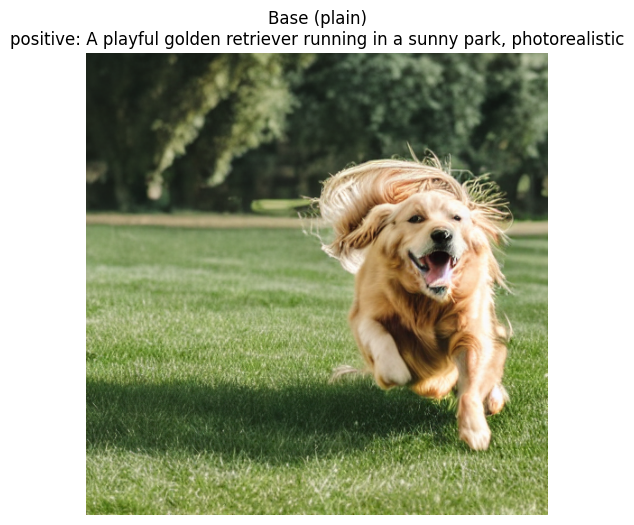

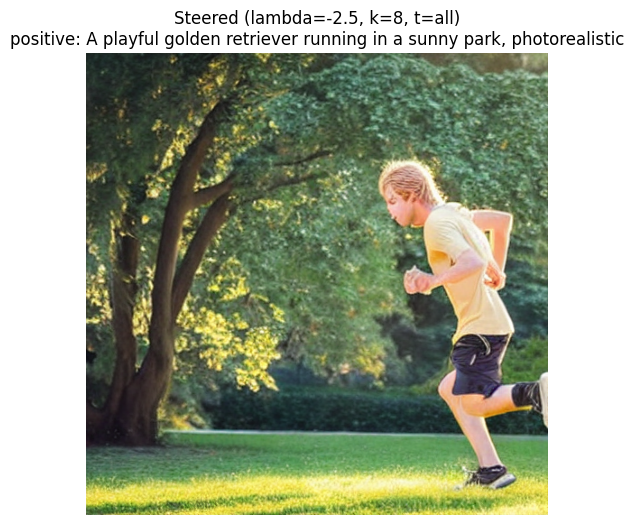

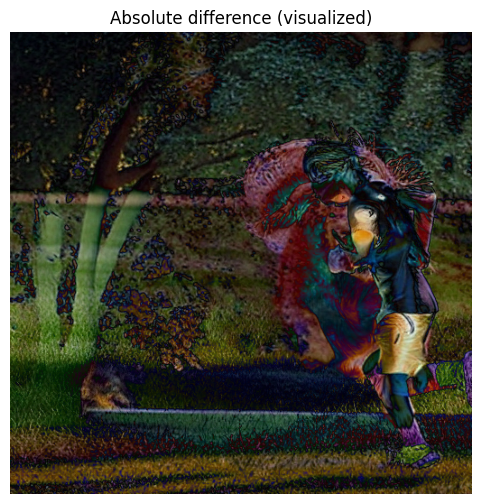

Saved:
 - .//final_demo/base_plain_pair=0_k=8_t=all.png
 - .//final_demo/steered_pair=0_lambda=-2.5_k=8_t=all.png
Pair used:
 + A playful golden retriever running in a sunny park, photorealistic
 - A playful child running in a sunny park, photorealistic


In [24]:
def steer_activations(x, r, lam=-1.0):
    if torch.all(r == 0).item():
        return x

    r = r.to(x.device, x.dtype)
    r /= r.norm()
        
    if x.ndim == 4:  # [B, C, H, W]
        r = r[None, :, None, None] # shape [B, C, 1, 1]
        channel_dim = 1
    elif x.ndim == 3: # [B, T, C] (ff layers)
        r = r[None, None, :] # shape [B, C]
        channel_dim = 2
        
    dot_product = (x * r).sum(dim=channel_dim, keepdim=True)
    
    return x + (lam * dot_product * r)


def steer_activations_pca(x, r, pca_data: tuple[torch.Tensor, torch.Tensor], lam: float = -1.0):
    #print(f'Steering on {x.shape} with {r.shape}')
    if torch.all(r == 0).item():
        return x

    r = r.to(x.device, x.dtype)

    pcs = pca_data[0].half().to(x.device)
    mean = pca_data[1].half().to(x.device)

    #print(f'{x.shape}, {mean.shape}')
    #x -= mean

    x_compressed = (x - mean) @ pcs
    x_compressed = x @ pcs
    r_compressed = r @ pcs
    r_constructed = (r_compressed @ pcs.T) + mean
    
    r_compressed /= r_compressed.norm()
    r_constructed /= r_constructed.norm()
        
    if x.ndim == 4:  # [B, C, H, W]
        r = r[None, :, None, None] # shape [B, C, 1, 1]
        channel_dim = 1
    elif x.ndim == 3: # [B, T, C] (attention layers)
        r = r[None, None, :] # shape [B, C]
        channel_dim = 2
        
    dot_product = (x_compressed * r_compressed).sum(dim=channel_dim, keepdim=True)
    
    return x + (lam * dot_product * r_constructed)


def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    nets: dict,
    steering_vectors: dict[str, torch.Tensor],
    timesteps: list[int],
    inference_steps: int,
    lam: float,
    pca_dict: dict[str, dict[int, tuple[torch.Tensor, torch.Tensor]]]
):
    handles = []

    current_step = 0

    def steering_hook(layer: str, steering_vector: torch.Tensor):
        ts_index = 0
        
        def hook(module, inp, out):
            nonlocal ts_index
            #print(f"[STEERING] layer={layer_name} step={current_step}")

            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, activation = out
            else:
                hidden, activation = None, out  # activation: [B, C, H, W]

            if current_step in timesteps: 
                #print(f'[{layer}] -> Step {current_step}, ts_index {ts_index}')
                B = activation.size(0)

                assert B % 2 == 0
                
                x = activation[B // 2 :, :, :]

                pca_data = pca_dict.get(layer, {}).get(current_step, None) if pca_dict is not None else None

                if pca_data is not None:
                    x_steered = steer_activations_pca(x, steering_vector[ts_index], pca_data, lam)
                else:
                    x_steered = steer_activations(x, steering_vector[ts_index], lam)
                
                activation[B // 2 :] = x_steered
                    
                ts_index += 1

            if hidden is None:
                return activation
            else:
                return (hidden, activation)

        return hook

    for layer, steering_vector in steering_vectors.items():
        handles.append(
            nets[layer].register_forward_hook(steering_hook(layer, steering_vector))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        return pipe(
            prompt,
            num_inference_steps=inference_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback,
            generator=torch.Generator(device="cuda").manual_seed(362)
        ).images
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()


# Run generation with steering


LAMBDA_PARAMS = [-2.5]
K_PARAMS = [8]
TIMESTEP_PARAMS = ["all"]

lam = LAMBDA_PARAMS[0]
k = K_PARAMS[0]
t = TIMESTEP_PARAMS[0]

OUTPUT_DIR = "./"
os.makedirs(f"{OUTPUT_DIR}/final_demo", exist_ok=True)

# ---- pick one pair from your inline list ----
PAIR_IDX = 0  # <-- cambia questo (0..49)
FINAL_POS_PROMPT = caption_pairs[PAIR_IDX]["positive"]
FINAL_NEG_PROMPT = caption_pairs[PAIR_IDX]["negative"]  # se ti serve dopo

# ----- 1) BASE: plain pipe (no steering) -----
base_img = pipe(
    [FINAL_POS_PROMPT],
    guidance_scale=GUIDANCE,
    num_inference_steps=STEPS,
    generator=torch.Generator(device="cuda").manual_seed(362),
).images[0]

base_path = f"{OUTPUT_DIR}/final_demo/base_plain_pair={PAIR_IDX}_k={k}_t={t}.png"
base_img.save(base_path)

# ----- 2) STEERED: keep the exact old logic that works -----
top_k_per_timestep = get_top_k_layers(results, k=k)
filtered_vectors = mask_vectors_by_top_k(
    steering_vectors,
    timesteps=get_timesteps_by_name(STEPS, t),
    top_k_per_timestep=top_k_per_timestep
)

steered_img = generate_with_steering(
    pipe,
    [FINAL_POS_PROMPT],
    GUIDANCE,
    nets,
    filtered_vectors,
    timesteps=get_timesteps_by_name(STEPS, t),
    inference_steps=STEPS,
    lam=lam,
    pca_dict=None
)[0]

steered_path = f"{OUTPUT_DIR}/final_demo/steered_pair={PAIR_IDX}_lambda={lam}_k={k}_t={t}.png"
steered_img.save(steered_path)

# ----- 3) SHOW base, steered, diff -----
base_np = np.array(base_img).astype(np.float32) / 255.0
steered_np = np.array(steered_img).astype(np.float32) / 255.0

diff = np.abs(steered_np - base_np)
diff_vis = diff / (diff.max() + 1e-8)

plt.figure(figsize=(6, 6))
plt.title(f"Base (plain)\npositive: {FINAL_POS_PROMPT}")
plt.axis("off")
plt.imshow(base_np)
plt.show()

plt.figure(figsize=(6, 6))
plt.title(f"Steered (lambda={lam}, k={k}, t={t})\npositive: {FINAL_POS_PROMPT}")
plt.axis("off")
plt.imshow(steered_np)
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Absolute difference (visualized)")
plt.axis("off")
plt.imshow(diff_vis)
plt.show()

print("Saved:")
print(" -", base_path)
print(" -", steered_path)
print("Pair used:")
print(" +", FINAL_POS_PROMPT)
print(" -", FINAL_NEG_PROMPT)


In [ ]:
!zip -r final_demo.zip final_demo
